# Quora Insincere Question Classification

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
from numpy.testing import assert_allclose
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from textblob import TextBlob
#from spacy_langdetect import LanguageDetector
#from langdetect import detect
#import swifter
import datetime
import spacy
import os
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential 
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPooling1D,Conv1D,SpatialDropout1D,Concatenate
from keras.models import Model
from keras.layers import CuDNNGRU,CuDNNLSTM
from keras.layers import GlobalAveragePooling1D
from tensorflow.keras import layers
from keras.layers import Flatten
from tensorflow.keras import regularizers
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd  /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
#loading preprocssed data

data = pd.read_csv('train_que_preprocessed.csv')

train_df = pd.read_csv('train.csv')

Y = train_df['target']

data.head(10)

,question,question_len,num_of_words,num_of_sentences,unique_words,stop_words
0,how did quebec nationalists see their province...,72,13,1,13,6
1,do you have an adopted dog how would you encou...,81,16,1,15,8
2,why does velocity affect time does velocity af...,67,10,2,8,1
3,how did otto von guericke used the magdeburg h...,57,9,1,9,2
4,can i convert montra helicon d to a mountain b...,77,15,1,15,5
5,is gaza slowly becoming auschwitz dachau or tr...,72,10,1,10,2
6,why does quora automatically ban conservative ...,113,18,1,17,9
7,is it crazy if i wash or wipe my groceries off...,69,14,2,14,6
8,is there such a thing as dressing moderately a...,102,18,1,17,11
9,is it just me or have you ever been in this ph...,246,44,2,39,23


In [ ]:
%%time

#removing special chars
def nospecial(text):
	text = re.sub("[^a-zA-Z0-9\s]+", "",text)
	return text

data['question'] = data['question'].apply(str).apply(nospecial)

# checking no.of data points in each class
print('No.of Datapoints in class-0 before split:',Y.value_counts()[0]) 
print('No.of Datapoints in class-1 before split:',Y.value_counts()[1])

#spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.1,stratify = Y)

print('\n')
print('No.of datapoints in training set after the split:',X_train.shape[0])
print('No.of datapoints in test set after the split:',X_test.shape[0])
print('\n')

#print no.of data points that belong to each class after split
print('No.of datapoints in Train data that belong to class-0:',(y_train.shape[0]-y_train.sum()))
print('No.of datapoints in Train data that belong to class-1:',y_train.sum())

#fill null values with empty string

X_train.fillna('',inplace = True)
X_test.fillna('',inplace = True)

No.of Datapoints in class-0 before split: 1225312
No.of Datapoints in class-1 before split: 80810


No.of datapoints in training set after the split: 1175509
No.of datapoints in test set after the split: 130613


No.of datapoints in Train data that belong to class-0: 1102780
No.of datapoints in Train data that belong to class-1: 72729
CPU times: user 4.45 s, sys: 40.3 ms, total: 4.49 s
Wall time: 4.49 s


In [ ]:
del data
gc.collect()

283

In [ ]:
%%time

# truncating sentences that have length greater than the 95%le of length of the questions
que_lens = X_train['question'].str.split(' ').apply(len)
max_len = int(np.percentile(que_lens,99))


max_features = 70000 # max features(words) considered to train the model

# since word embedding layer requires words to be indexed, assigning indices to words in the data
text_vectorizer = layers.TextVectorization(max_tokens=max_features,output_mode='int',output_sequence_length=max_len)
text_vectorizer.adapt(X_train['question']) 
text_to_index = {v: k for k, v in dict(enumerate(text_vectorizer.get_vocabulary())).items()}

def text_2_seq(sentence):
  '''converts sentences with words to sentences with indices
        params: sentence (text to convert into indices)'''

  text_seq = []
  for word in sentence.split(' '):
    if word in text_to_index.keys():
      text_seq.append(text_to_index[word])
    else:
      text_seq.append(1)
  return text_seq

train_text_indices = X_train['question'].apply(text_2_seq)
test_text_indices = X_test['question'].apply(text_2_seq)

# padding sequences to length equal to 95%le of sentence lengths
train = pad_sequences(train_text_indices, maxlen=max_len,padding='post')
test = pad_sequences(test_text_indices, maxlen=max_len,padding='post')

CPU times: user 6min 54s, sys: 7.64 s, total: 7min 2s
Wall time: 5min 42s


In [ ]:
#https://www.kaggle.com/code/sudalairajkumar/a-look-at-different-embeddings/notebook

# below func creates a embedding file for the words

def get_embeddings(file_path):
  EMBEDDING_FILE = file_path #path to location where embedding file(glove,paragam...) is located
  embed_size = 300 #dimension of word embeddings

  embeddings_index = dict() #dictionary to store word embeddings

  def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32') #splits words and embeddings from embedding file and returns embedding and word
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100) #add words and embeddings to dictionary

  no_wordVec_voc = [] # list of no.of words that are not in the embedding file

  #count no.of words that are not in embedding file
  for word in text_to_index.keys():
    if word not in embeddings_index.keys():
      no_wordVec_voc.append(word)

  print('No.of words that donot have word vector in glove embeddings:',len(no_wordVec_voc),', below are few words,\n')

  #print few words that are not in embedding file
  for word in no_wordVec_voc[2:20]:
    print(word)

  #calculate mean and std of all embeddings to generate a random normal vector for words that do not have an embedding  vector
  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = all_embs.mean(), all_embs.std() 
  embed_size = all_embs.shape[1]

  # generate embedding matrix
  nb_words = max_features
  embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
  for word, i in text_to_index.items():
    
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None: embedding_matrix[i] = embedding_vector
  
  return embedding_matrix

In [ ]:
%%time
# generate glove embeddings matrix
glove_embeddings = get_embeddings('/content/drive/MyDrive/Kaggle/glove.840B.300d/glove.840B.300d.txt')

No.of words that donot have word vector in glove embeddings: 6156 , below are few words,

quorans
brexit
cryptocurrencies
redmi
kvpy
paytm
iiser
ethereum
iisc
jinping
viteee
iocl
nmims
fortnite
rohingya
upes
cpec
nsit
CPU times: user 2min 2s, sys: 18.7 s, total: 2min 21s
Wall time: 2min 34s


In [ ]:
%%time
#generate paragram embeddings
paragram_embeddings = get_embeddings('/content/drive/MyDrive/Kaggle/paragram_300_sl999/paragram_300_sl999.txt')

No.of words that donot have word vector in glove embeddings: 2650 , below are few words,

quorans
brexit
cryptocurrencies
redmi
coinbase
oneplus
uceed
machedo
upwork
demonetisation
bhakts
adityanath
boruto
bnbr
gdpr
dceu
unacademy
litecoin
CPU times: user 1min 34s, sys: 10.2 s, total: 1min 44s
Wall time: 1min 55s


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("indigo")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

#### Building a model with LSTM and a Dense layer that takes word probabilities

In [ ]:
# Calculate word probs for dense layer inputs

#create bag words for sincere questions which are used to calculate the word probs
sincere_vectorizer = CountVectorizer(binary = True,vocabulary = text_vectorizer.get_vocabulary())
sincere_que = X_train[y_train == 0]['question']
sincere_bow = sincere_vectorizer.fit_transform(sincere_que) 

#create bag words for insincere questions which are used to calculate the word probs
insincere_vectorizer = CountVectorizer(binary = True,vocabulary = text_vectorizer.get_vocabulary())
insincere_que = X_train[y_train == 1]['question']
insincere_bow = insincere_vectorizer.fit_transform(insincere_que) 

# below code generate the count of each word occured in the sincere questions corpus. from the above generated BOW matrix, sum along the columns returns count of
# each word in the corpus
sincere_bow = pd.DataFrame(sincere_bow.sum(axis = 0).A1,index = sincere_vectorizer.vocabulary_)

# below code generate the count of each word occured in the insincere questions corpus. from the above generated BOW matrix, sum along the columns returns count of
# each word in the corpus
insincere_bow = pd.DataFrame(insincere_bow.sum(axis = 0).A1,index = sincere_vectorizer.vocabulary_)

sincere_probs = {} #saves word probs of each word in sincere question corpus
insincere_probs = {} #saves word probs of each word in insincere question corpus

#calculate word probs
for word in sincere_vectorizer.vocabulary_.keys():
  sincere_probs[word] = sincere_bow.loc[word].values[0] / sincere_que.shape[0]
  insincere_probs[word] = insincere_bow.loc[word].values[0] / insincere_que.shape[0]
  

In [ ]:
del sincere_vectorizer,sincere_que,sincere_bow,insincere_vectorizer,insincere_que,insincere_bow
gc.collect()

15

In [ ]:
# assign word probs to each question

def get_probs_df(que):
  '''generates an array with word probs for each class of a question'''    
  word_probs = [] # list word probs for each class if word is in top 70000 words else 0
  for word in que.split(' '):
      if sincere_probs.get(word) is not None: 
        word_probs.append(sincere_probs[word])
        word_probs.append(insincere_probs[word])
      else:
          word_probs.append(0)
          word_probs.append(0)

    # pad or truncate the arrays to make all the prob arrays of same size
  if len(word_probs) > max_len*2:
      word_probs = word_probs[:max_len*2]
  elif len(word_probs) < max_len*2:
      ext = [0]*(max_len*2 - len(word_probs))
      word_probs.extend(ext)

  return np.array(word_probs)

train_probs = X_train['question'].apply(get_probs_df)
test_probs = X_test['question'].apply(get_probs_df)
#cv_probs = X_cv['question'].apply(get_probs_df)

#cv_probs = np.stack(cv_probs.values)
train_probs = np.stack(train_probs.values)
test_probs = np.stack(test_probs.values)



In [ ]:
from sklearn.preprocessing import StandardScaler

# standardizing the statistical features 
train_stat_feats = X_train.drop(['question'],axis = 1)
#cv_stat_feats = X_cv.drop(['question'],axis = 1)
test_stat_feats = X_test.drop(['question'],axis = 1)

scaler = StandardScaler()
scaler.fit(train_stat_feats) 

train_stat_feats_norm = scaler.transform(train_stat_feats)
#cv_stat_feats_norm = scaler.transform(cv_stat_feats)
test_stat_feats_norm = scaler.transform(test_stat_feats)

train_stats_merge = np.concatenate((train_stat_feats_norm,train_probs),axis = 1)
#cv_stats_merge = np.concatenate((cv_stat_feats_norm,cv_probs),axis = 1)
test_stats_merge = np.concatenate((test_stat_feats_norm,test_probs),axis = 1)

print(train_stats_merge.shape)

(1175509, 85)


In [ ]:
del scaler,train_stat_feats_norm,test_stat_feats_norm,train_probs,test_probs

## Training the model

### LSTM Model with added features idf vals, text stats and word probabilities

In [ ]:
# Calculate idf values for dense layer inputs


sincere_vectorizer = TfidfVectorizer(binary = True,vocabulary = text_vectorizer.get_vocabulary())
sincere_que = X_train['question']
sincere_tfidf = sincere_vectorizer.fit_transform(sincere_que)

sincere_idf_dict = dict(zip(sincere_vectorizer.get_feature_names_out(),sincere_vectorizer.idf_))

def get_idf_vector(question):
  que_idfs = []
  for word in question.split(' '):
    if (sincere_idf_dict.get(word) is not None):
        que_idfs.append(sincere_idf_dict[word])
        #que_idfs.append(insincere_idf_dict[word])
    else:
        que_idfs.append(0.1)
        #que_idfs.append(0.1)

  if len(que_idfs) > max_len:
        que_idfs = que_idfs[:max_len]
  elif len(que_idfs) < max_len:
        ext = [0]*(max_len - len(que_idfs))
        que_idfs.extend(ext)

  return np.array(que_idfs)


In [ ]:
train_idf = X_train['question'].apply(get_idf_vector)
train_idf = np.stack(train_idf.values)

test_idf = X_test['question'].apply(get_idf_vector)
test_idf = np.stack(test_idf.values)

print(train_idf.shape)
#print(cv_idf.shape)
print(test_idf.shape)

(1175509, 40)
(130613, 40)


In [ ]:
del sincere_vectorizer,sincere_que,sincere_tfidf
gc.collect()

44

In [ ]:
from sklearn.preprocessing import Normalizer

# normalizing the idf values

normalizer = Normalizer().fit(train_idf)

train_idf_norm = normalizer.transform(train_idf)
test_idf_norm = normalizer.transform(test_idf)

train_merge = np.concatenate((train_stats_merge,train_idf_norm),axis = 1)
test_merge = np.concatenate((test_stats_merge,test_idf_norm),axis = 1)

In [ ]:
del normalizer,train_idf_norm,test_idf_norm
gc.collect()

44

In [ ]:
# model architecture
dense_input = train_merge.shape[1] #dense layer input shape

def tfidf_model(embeddings = glove_embeddings):
  
  lstm_inputs = Input(shape = (max_len,),name = 'lstm_inputs')
  dense_inputs = Input(shape = (dense_input,),name = 'dense_inputs')
  
  embeddings = Embedding(input_dim = text_vectorizer.vocabulary_size(), output_dim=300,weights=[embeddings],trainable = False,)(lstm_inputs)
  x = SpatialDropout1D(0.5)(embeddings)
  x = Bidirectional(CuDNNLSTM(256, return_sequences=True,name='lstm_layer'))(x)
  x = Conv1D(126,2)(x)
  x = GlobalMaxPooling1D()(x)
  x = Dropout(0.1)(x)
  lstm_feats = Dense(32, activation="relu")(x)
  

  tfidf_feats = Dense(32, activation="relu")(dense_inputs)
  
  conc = tf.keras.layers.Concatenate()([lstm_feats,tfidf_feats])

  outputs = Dense(1, activation="sigmoid")(conc)

  return Model(inputs=[lstm_inputs,dense_inputs], outputs=outputs)


In [ ]:
# training the model

#save the model weights that has lower loss value
filepath="tfidf_best_weights.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model = tfidf_model()
model.compile(optimizer = tf.keras.optimizers.Adam(decay = 0.00001),loss = tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'] )
model.fit({'lstm_inputs':train,'dense_inputs':train_merge}, y_train.values,batch_size = 128, epochs=10, verbose=1,\
              validation_data=({'lstm_inputs':test,'dense_inputs':test_merge}, y_test.values),callbacks = [callbacks_list])

Epoch 1/10
9184/9184 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9539
Epoch 1: val_loss improved from inf to 0.10172, saving model to tfidf_best_weights.hdf5
9184/9184 [==============================] - 211s 21ms/step - loss: 0.1183 - accuracy: 0.9539 - val_loss: 0.1017 - val_accuracy: 0.9591
Epoch 2/10
9182/9184 [============================>.] - ETA: 0s - loss: 0.1058 - accuracy: 0.9582
Epoch 2: val_loss improved from 0.10172 to 0.09805, saving model to tfidf_best_weights.hdf5
9184/9184 [==============================] - 191s 21ms/step - loss: 0.1058 - accuracy: 0.9582 - val_loss: 0.0981 - val_accuracy: 0.9606
Epoch 3/10
9184/9184 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.9599
Epoch 3: val_loss improved from 0.09805 to 0.09602, saving model to tfidf_best_weights.hdf5
9184/9184 [==============================] - 191s 21ms/step - loss: 0.1008 - accuracy: 0.9599 - val_loss: 0.0960 - val_accuracy: 0.9613
Epoch 4/10
9182/9184 [====

In [ ]:
#load best model weights
model.load_weights("tfidf_best_weights.hdf5")

train_preds = model.predict([train,train_merge]) #train predictions
test_preds = model.predict([test,test_merge])#test predictions

result = threshold_search(y_train,train_preds) #choose the best f1 threshold value
print('Best thershold:',result['threshold'],', best score:',result['f1'])

test_result = threshold_search(y_test,test_preds)
print('Best thershold:',test_result['threshold'],', best score:',test_result['f1'])

Best thershold: 0.45 , best score: 0.7556060762633047
Best thershold: 0.36 , best score: 0.6970949782261175


In [ ]:
del model,train_preds,test_preds
gc.collect()

3508

In [ ]:
%%time
# training an ensemble of 5 models trained on same data

train_predictions = np.empty((train.shape[0],5)) #saves predictions of each model
test_predictions = np.empty((test.shape[0],5))


for ind in range(5):
  print('index:', ind)
  print('\n')
  filepath="tfidf_model"+str(ind)+"_ind.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]
  model = tfidf_model()
  model.compile(optimizer = tf.keras.optimizers.Adam(decay = 0.00001),loss = tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'] )
  model.fit({'lstm_inputs':train,'dense_inputs':train_merge}, y_train.values,batch_size = 256, epochs=6, verbose=1,\
              validation_data=({'lstm_inputs':test,'dense_inputs':test_merge}, y_test.values),callbacks = callbacks_list)

  model.load_weights(filepath)

  train_predictions[:,ind] = model.predict([train,train_merge]).ravel()
  test_predictions[:,ind] = model.predict([test,test_merge]).ravel()
  
  del model
  gc.collect()


# averaging all model preds
avg_preds_train = np.mean(train_predictions,axis = 1)
avg_preds_test = np.mean(test_predictions,axis = 1)

#simple method to choose best threshold value
thresholds = np.arange(0.1, 0.501, 0.01)
for thresh in thresholds:
      thresh = np.round(thresh, 2)
      print("Train F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_train,(avg_preds_train>thresh).astype(int))))
      print("Test F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_test,(avg_preds_test>thresh).astype(int))))
      print('-'*50)


index: 0


Epoch 1/6
4592/4592 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9529
Epoch 1: val_loss improved from inf to 0.10369, saving model to tfidf_model0_ind.hdf5
4592/4592 [==============================] - 162s 35ms/step - loss: 0.1202 - accuracy: 0.9529 - val_loss: 0.1037 - val_accuracy: 0.9589
Epoch 2/6
4591/4592 [============================>.] - ETA: 0s - loss: 0.1069 - accuracy: 0.9576
Epoch 2: val_loss improved from 0.10369 to 0.09883, saving model to tfidf_model0_ind.hdf5
4592/4592 [==============================] - 158s 35ms/step - loss: 0.1069 - accuracy: 0.9576 - val_loss: 0.0988 - val_accuracy: 0.9607
Epoch 3/6
4591/4592 [============================>.] - ETA: 0s - loss: 0.1020 - accuracy: 0.9594
Epoch 3: val_loss improved from 0.09883 to 0.09733, saving model to tfidf_model0_ind.hdf5
4592/4592 [==============================] - 158s 34ms/step - loss: 0.1020 - accuracy: 0.9594 - val_loss: 0.0973 - val_accuracy: 0.9612
Epoch 4/6
4591/4592 [===

Test F1-score: 0.7025239338555266
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122532
           1       0.66      0.75      0.70      8081

    accuracy                           0.96    130613
   macro avg       0.82      0.86      0.84    130613
weighted avg       0.96      0.96      0.96    130613



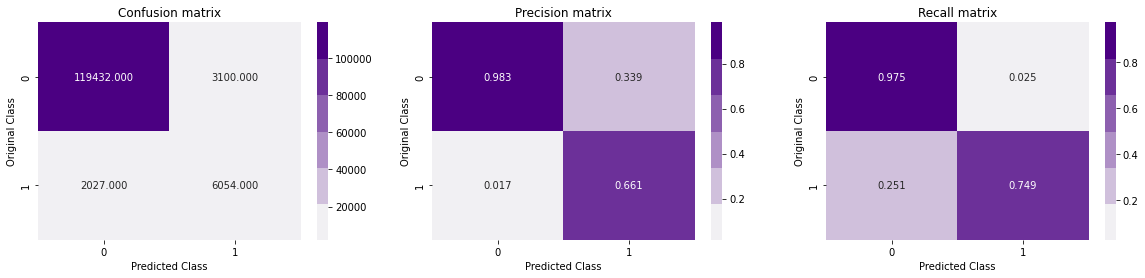

In [ ]:
print('Test F1-score:',metrics.f1_score(y_test,(avg_preds_test>0.37).astype(int)))

y_pred_test = [1 if pred > 0.37 else 0 for pred in avg_preds_test]
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(y_test, y_pred_test)

- Ensembele of the model appears to be performing slightly better than the single model, f1-score increased from 0.697 to 0.70.

- Model has classified 6054 insincere questions correctly out of 8081 insincere with ~0.75 recall score and 0.66 precision score, model appears to be doing a good job in predicting insincere questions but the precision is a bit low.

### BERT based word embeddings

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.2 MB/s 
     |████████████████████████████████| 596 kB 66.4 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 6.6 MB 49.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
que_lens = X_train['question'].str.split(' ').apply(len)
max_len = int(np.percentile(que_lens,99))
max

<function max>

In [ ]:
#https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379

from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

'''data = pd.read_csv('train_que_preprocessed.csv') 
data.fillna('',inplace = True)
'''
que_lens = X_train['question'].str.split(' ').apply(len)
MAX_LENGTH = int(np.percentile(que_lens,99))



# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='max_length', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)
    
    
# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train['question'].tolist())

# Encode X_cv
#X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_cv['question'].tolist())

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test['question'].tolist())

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
  layer.trainable = False

#LEARNING_RATE = 5e-5

def build_model(transformer, max_length=MAX_LENGTH):
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # We only care about DistilBERT's output for the [CLS] token, 
    # which is located at index 0 of every encoded sequence.  
    # Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state
    
    ##                                                 ##
    ## Define additional dropout and dense layers here ##
    ##                                                 ##
    
    # Define a single node that makes up the output layer (for binary classification)
    
    x = Bidirectional(CuDNNLSTM(256, return_sequences=True,name='lstm_layer'))(cls_token)
    x = Conv1D(126,2)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.1)(x)
    lstm_feats = Dense(32, activation="relu")(x)
  

    output = tf.keras.layers.Dense(1,activation='sigmoid')(lstm_feats)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    
    return model

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model = build_model(distilBERT)

history = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.values,
    epochs = 5,
    batch_size = 256,
    validation_data = ([X_test_ids, X_test_attention], y_test.values),
    verbose=1)

Epoch 1/5
4592/4592 [==============================] - 2015s 435ms/step - loss: 0.1087 - accuracy: 0.9568 - val_loss: 0.1023 - val_accuracy: 0.9587
Epoch 2/5
4592/4592 [==============================] - 1986s 432ms/step - loss: 0.0973 - accuracy: 0.9609 - val_loss: 0.0980 - val_accuracy: 0.9602
Epoch 3/5
4592/4592 [==============================] - 1989s 433ms/step - loss: 0.0921 - accuracy: 0.9628 - val_loss: 0.0961 - val_accuracy: 0.9610
Epoch 4/5
3053/4592 [==================>...........] - ETA: 10:07 - loss: 0.0879 - accuracy: 0.9643

In [ ]:
model.save_weights('bertmodel.hdf5')

In [ ]:
#model = build_model(distilBERT)
model.load_weights("bertmodel.hdf5")

train_pred = model.predict([X_train_ids, X_train_attention])
test_pred = model.predict([X_test_ids, X_test_attention])

thresholds = np.arange(0.1, 0.501, 0.01)
for thresh in thresholds:
      thresh = np.round(thresh, 2)
      print("Train F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_train,(train_pred>thresh).astype(int))))
      print("Test F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_cv,(cv_pred>thresh).astype(int))))
      print('-'*50)

In [ ]:
print('Test F1-score:',metrics.f1_score(y_test,(test_preds>0.34).astype(int)))

y_pred_test = [1 if pred > 0.34 else 0 for pred in test_preds]
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(y_test, y_pred_test)

In [ ]:
del model,data
gc.collect()

18314

In [ ]:
%%time

filepath="best_tfidf_model.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model = tfidf_model()

model.compile(optimizer = tf.keras.optimizers.Adam(decay = 0.00001),loss = tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'] )

model.fit({'lstm_inputs':train,'dense_inputs':train_merge}, y_train.values,batch_size = 128, epochs=8, verbose=1,\
              validation_data=({'lstm_inputs':cv,'dense_inputs':cv_merge}, y_cv.values),callbacks=[callbacks_list])

train_preds = model.predict([train,train_merge])
cv_preds = model.predict([cv,cv_merge])
test_preds = model.predict([test,test_merge])

thresholds = np.arange(0.1, 0.501, 0.01)
for thresh in thresholds:
      thresh = np.round(thresh, 2)
      print("Train F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_train,(train_preds>thresh).astype(int))))
      print("Test F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_cv,(cv_preds>thresh).astype(int))))
      print('-'*50)

Epoch 1/8
8265/8266 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9524
Epoch 1: val_loss improved from inf to 0.10707, saving model to best_tfidf_model.hdf5
8266/8266 [==============================] - 136s 16ms/step - loss: 0.1211 - accuracy: 0.9524 - val_loss: 0.1071 - val_accuracy: 0.9573
Epoch 2/8
8265/8266 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9573
Epoch 2: val_loss improved from 0.10707 to 0.10378, saving model to best_tfidf_model.hdf5
8266/8266 [==============================] - 136s 16ms/step - loss: 0.1076 - accuracy: 0.9573 - val_loss: 0.1038 - val_accuracy: 0.9582
Epoch 3/8
8265/8266 [============================>.] - ETA: 0s - loss: 0.1025 - accuracy: 0.9591
Epoch 3: val_loss improved from 0.10378 to 0.10198, saving model to best_tfidf_model.hdf5
8266/8266 [==============================] - 136s 16ms/step - loss: 0.1025 - accuracy: 0.9591 - val_loss: 0.1020 - val_accuracy: 0.9597
Epoch 4/8
8266/8266 [==============

Test F1-score: 0.6805351084938872
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    110278
           1       0.64      0.73      0.68      7273

    accuracy                           0.96    117551
   macro avg       0.81      0.85      0.83    117551
weighted avg       0.96      0.96      0.96    117551



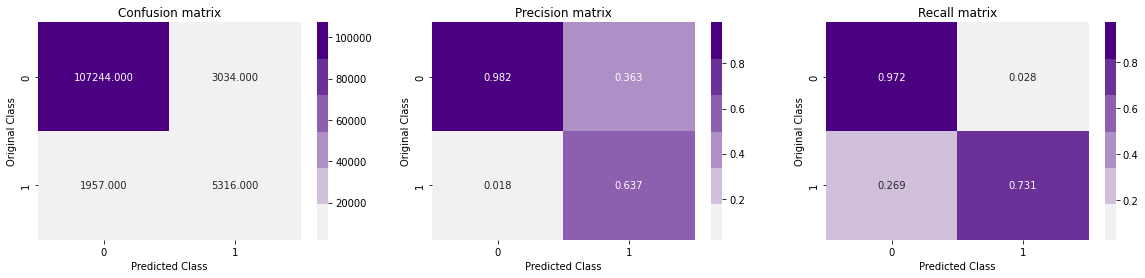

In [ ]:
print('Test F1-score:',metrics.f1_score(y_test,(test_preds>0.34).astype(int)))

y_pred_test = [1 if pred > 0.34 else 0 for pred in test_preds]
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(y_test, y_pred_test)

- LSTM model trained on BERT based embeddings gave an f1-score of 0.68 which is less than that of the LSTM model with glove embeddings.

- Even precision and recall values are less than that of the glove embeddings based model.

### Classical ML models

One hot encoding 

In [ ]:
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
#X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.1,stratify = Y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.1,stratify = y_train)

(1057958, 6) (117551, 6) (130613, 6)


In [ ]:
count_vectorizer = CountVectorizer(min_df = 10,ngram_range = (1,1))
count_vectorizer.fit(X_train['question'])

train_one_hot = count_vectorizer.transform(X_train['question'])
cv_one_hot = count_vectorizer.transform(X_cv['question'])
test_one_hot = count_vectorizer.transform(X_test['question'])

print(train_one_hot.shape)
print(cv_one_hot.shape)
print(test_one_hot.shape)

train_data = hstack((train_one_hot, X_train.drop(['question'],axis = 1).values))
cv_data = hstack((cv_one_hot, X_cv.drop(['question'],axis = 1).values))
test_data = hstack((test_one_hot, X_test.drop(['question'],axis = 1).values))


scaler = StandardScaler(with_mean=False,)
train_std = scaler.fit_transform(train_data)
cv_std = scaler.transform(cv_data)
test_std = scaler.transform(test_data)

(1057958, 29918)
(117551, 29918)
(130613, 29918)


In [ ]:
#del model
gc.collect()

11637

TF-IDF vectorization

In [ ]:
vectorizer = TfidfVectorizer(min_df = 10,ngram_range = (1,1))
vectorizer.fit(X_train['question'])

print('No.of words in the vocabulary',len(vectorizer.get_feature_names_out()))

train_tfidf = vectorizer.transform(X_train['question'])
cv_tfidf = vectorizer.transform(X_cv['question'])
test_tfidf = vectorizer.transform(X_test['question'])

print(train_tfidf.shape)
print(cv_tfidf.shape)
print(test_tfidf.shape)

train_data = hstack((train_tfidf, X_train.drop(['question'],axis = 1).values))
cv_data = hstack((cv_tfidf, X_cv.drop(['question'],axis = 1).values))
test_data = hstack((test_tfidf, X_test.drop(['question'],axis = 1).values))

scaler = StandardScaler(with_mean=False,)
train_std = scaler.fit_transform(train_data)
cv_std = scaler.transform(cv_data)
test_std = scaler.transform(test_data)

No.of words in the vocabulary 29918
(1057958, 29918)
(117551, 29918)
(130613, 29918)


Logit model with SGD classifier

training with Bag of words encoded text

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, log_loss

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf_sgd = SGDClassifier(loss = 'log')
params = {'alpha':[10 ** x for x in range(-5, 4)],'class_weight':[{0:0.1,1:0.9},{0:0.2,1:0.8},'balanced']}
gd = GridSearchCV(cv=3,estimator=clf_sgd,param_grid=params,return_train_score=True,scoring='f1')
gd.fit(train_std, y_train);

In [ ]:
results = pd.DataFrame.from_dict(gd.cv_results_)
results = results.sort_values(['param_alpha'])

print('BEST-PARAMS:::\t',gd.best_params_)
print('BEST-SCORE:::\t',gd.best_score_)

BEST-PARAMS:::	 {'alpha': 0.01, 'class_weight': {0: 0.2, 1: 0.8}}
BEST-SCORE:::	 0.5842493128384731


In [ ]:
%%time
clf = SGDClassifier(loss = 'log',alpha=gd.best_params_['alpha'],class_weight=gd.best_params_['class_weight'])
clf.fit(train_std, y_train)

train_prediction = clf.predict_proba(train_std)
print('For values of best alpha ', "The train log loss is:",log_loss(y_train, train_prediction, labels=clf.classes_, eps=1e-15))

cv_prediction = clf.predict_proba(cv_std)
print('For values of best alpha ', "The cv log loss is:",log_loss(y_cv, cv_prediction, labels=clf.classes_, eps=1e-15))

test_prediction = clf.predict_proba(test_std)
print('For values of best alpha', "The test log loss is:",log_loss(y_test, test_prediction, labels=clf.classes_, eps=1e-15))


For values of best alpha  The train log loss is: 0.16899439096406266
For values of best alpha  The cv log loss is: 0.1799231869710003
For values of best alpha The test log loss is: 0.1799812463154925
CPU times: user 4.26 s, sys: 109 ms, total: 4.37 s
Wall time: 4.23 s


In [ ]:
thresholds = np.arange(0.4, 0.601, 0.01)
for thresh in thresholds:
      thresh = np.round(thresh, 2)
      print("Train F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_train,(train_prediction[:,1]>thresh).astype(int))))
      print("Test F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_cv,(cv_prediction[:,1]>thresh).astype(int))))
      print('-'*50)

Train F1 score at threshold 0.4 is 0.6056979430205698
Test F1 score at threshold 0.4 is 0.5710482200966375
--------------------------------------------------
Train F1 score at threshold 0.41 is 0.6100652449336108
Test F1 score at threshold 0.41 is 0.5738443065839504
--------------------------------------------------
Train F1 score at threshold 0.42 is 0.6138761916090332
Test F1 score at threshold 0.42 is 0.5774662196484812
--------------------------------------------------
Train F1 score at threshold 0.43 is 0.6174519788948536
Test F1 score at threshold 0.43 is 0.5804953560371519
--------------------------------------------------
Train F1 score at threshold 0.44 is 0.6206204571175228
Test F1 score at threshold 0.44 is 0.5838476828120097
--------------------------------------------------
Train F1 score at threshold 0.45 is 0.6239368812027585
Test F1 score at threshold 0.45 is 0.5862379967107009
--------------------------------------------------
Train F1 score at threshold 0.46 is 0.6267

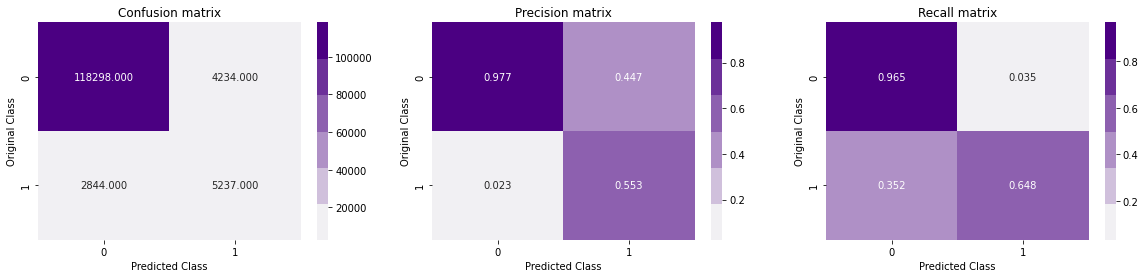

In [ ]:
predicted_y = (test_prediction[:,1]>0.57).astype(int)
plot_confusion_matrix(y_test, predicted_y)

Logit model with TFIDF features

In [ ]:
%%time
clf_sgd = SGDClassifier(loss = 'log')
params = {'alpha':[10 ** x for x in range(-5, 4)],'class_weight':[{0:0.1,1:0.9},{0:0.2,1:0.8},'balanced']}
gd = GridSearchCV(cv=3,estimator=clf_sgd,param_grid=params,return_train_score=True,scoring='f1')
gd.fit(train_std, y_train);

results = pd.DataFrame.from_dict(gd.cv_results_)
results = results.sort_values(['param_alpha'])

print('BEST-PARAMS:::\t',gd.best_params_)
print('BEST-SCORE:::\t',gd.best_score_)

clf = SGDClassifier(loss = 'log',alpha=gd.best_params_['alpha'],class_weight=gd.best_params_['class_weight'])
clf.fit(train_std, y_train)

train_prediction = clf.predict_proba(train_std)
print('For values of best alpha ', "The train log loss is:",log_loss(y_train, train_prediction, labels=clf.classes_, eps=1e-15))

cv_prediction = clf.predict_proba(cv_std)
print('For values of best alpha ', "The cv log loss is:",log_loss(y_cv, cv_prediction, labels=clf.classes_, eps=1e-15))

test_prediction = clf.predict_proba(test_std)
print('For values of best alpha', "The test log loss is:",log_loss(y_test, test_prediction, labels=clf.classes_, eps=1e-15))


BEST-PARAMS:::	 {'alpha': 0.1, 'class_weight': {0: 0.2, 1: 0.8}}
BEST-SCORE:::	 0.5714615928189125
For values of best alpha  The train log loss is: 0.2014236832472745
For values of best alpha  The cv log loss is: 0.2198893710919941
For values of best alpha The test log loss is: 0.21870233404077483
CPU times: user 16min 3s, sys: 9.83 s, total: 16min 13s
Wall time: 16min


In [ ]:
thresholds = np.arange(0.3, 0.601, 0.01)
for thresh in thresholds:
      thresh = np.round(thresh, 2)
      print("Train F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_train,(train_prediction[:,1]>thresh).astype(int))))
      print("Test F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_cv,(cv_prediction[:,1]>thresh).astype(int))))
      print('-'*50)

Train F1 score at threshold 0.3 is 0.5163278361893414
Test F1 score at threshold 0.3 is 0.51599603567889
--------------------------------------------------
Train F1 score at threshold 0.31 is 0.5230664415711931
Test F1 score at threshold 0.31 is 0.522389272653393
--------------------------------------------------
Train F1 score at threshold 0.32 is 0.5292484540579376
Test F1 score at threshold 0.32 is 0.5291225731189068
--------------------------------------------------
Train F1 score at threshold 0.33 is 0.5351148409893993
Test F1 score at threshold 0.33 is 0.5337595907928389
--------------------------------------------------
Train F1 score at threshold 0.34 is 0.5403861053719009
Test F1 score at threshold 0.34 is 0.5390461215932913
--------------------------------------------------
Train F1 score at threshold 0.35 is 0.5449692940943408
Test F1 score at threshold 0.35 is 0.5442298255788018
--------------------------------------------------
Train F1 score at threshold 0.36 is 0.5494285

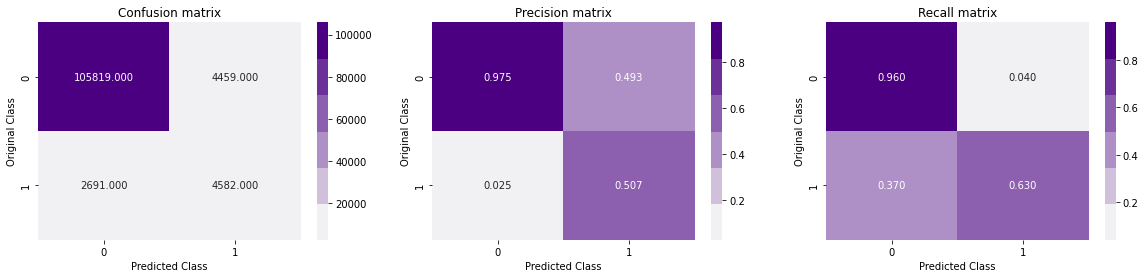

In [ ]:
predicted_y = (test_prediction[:,1]>0.46).astype(int)
plot_confusion_matrix(y_test, predicted_y)

- Logistic regression model trained on BOW gave f1-score of 0.60 on the test data which is a very less score compared to the LSTM model. Loss value of  the Logit model on test data is 0.17 which is much higher than the LSTM model.

- Looking at the confusion matrices Precision on insincere questions is 0.55 and recall is 0.648 which again is very low compared to the LSTM model.

- Training the model on tfidf didn't improve the score but the score got much worse.

#### Training Naive Bayes

tfidf-encoded data

In [ ]:
%%time
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
params = {'alpha':[10 ** x for x in range(-5, 4)]}
gd = GridSearchCV(cv=3,estimator=clf,param_grid=params,return_train_score=True,scoring='f1')
gd.fit(train_std, y_train);

results = pd.DataFrame.from_dict(gd.cv_results_)
results = results.sort_values(['param_alpha'])

print('BEST-PARAMS:::\t',gd.best_params_)
print('BEST-SCORE:::\t',gd.best_score_)

clf = MultinomialNB(alpha=gd.best_params_['alpha'])
clf.fit(train_one_hot, y_train)

train_prediction = clf.predict_proba(train_one_hot)
print('For values of best alpha ', "The train log loss is:",log_loss(y_train, train_prediction, labels=clf.classes_, eps=1e-15))

cv_prediction = clf.predict_proba(cv_one_hot)
print('For values of best alpha ', "The cv log loss is:",log_loss(y_cv, cv_prediction, labels=clf.classes_, eps=1e-15))

test_prediction = clf.predict_proba(test_one_hot)
print('For values of best alpha', "The test log loss is:",log_loss(y_test, test_prediction, labels=clf.classes_, eps=1e-15))


BEST-PARAMS:::	 {'alpha': 1}
BEST-SCORE:::	 0.5423426609690813
For values of best alpha  The train log loss is: 0.28228051811244526
For values of best alpha  The cv log loss is: 0.29140767743303025
For values of best alpha The test log loss is: 0.2920944256171269
CPU times: user 20.6 s, sys: 566 ms, total: 21.2 s
Wall time: 21 s


for alpha = 1e-05
Log Loss : 0.13830952124079984
for alpha = 0.0001
Log Loss : 0.1354236858200767
for alpha = 0.001
Log Loss : 0.13268468749565346
for alpha = 0.1
Log Loss : 0.12878560305910192
for alpha = 1
Log Loss : 0.1316965567446247
for alpha = 10
Log Loss : 0.2510698687202821
for alpha = 100
Log Loss : 1.6557011282974545
for alpha = 1000
Log Loss : 2.1352154491217106


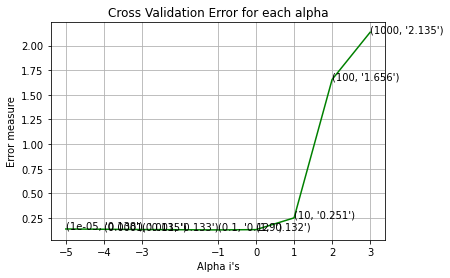

For values of best alpha =  0.1 The train log loss is: 0.12276195057040636
For values of best alpha =  0.1 The cross validation log loss is: 0.12878560305910192
For values of best alpha =  0.1 The test log loss is: 0.12974173094026956


In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_data, y_train)

    clf_probs = clf.predict_proba(cv_data)
    cv_log_error_array.append(log_loss(y_cv, clf_probs, labels=clf.classes_, eps=1e-15))
    
    print("Log Loss :",log_loss(y_cv, clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_data, y_train)


train_predict = clf.predict_proba(train_data)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, train_predict, labels=clf.classes_, eps=1e-15))
cv_predict = clf.predict_proba(cv_data)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, cv_predict, labels=clf.classes_, eps=1e-15))
test_predict = clf.predict_proba(test_data)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, test_predict, labels=clf.classes_, eps=1e-15))

In [ ]:
thresholds = np.arange(0.1, 0.601, 0.01)
for thresh in thresholds:
      thresh = np.round(thresh, 2)
      print("Train F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_train,(train_predict[:,1]>thresh).astype(int))))
      print("Test F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(y_cv,(cv_predict[:,1]>thresh).astype(int))))
      print('-'*50)

Train F1 score at threshold 0.1 is 0.5019850645421985
Test F1 score at threshold 0.1 is 0.4938704028021016
--------------------------------------------------
Train F1 score at threshold 0.11 is 0.516410913176352
Test F1 score at threshold 0.11 is 0.5071798296877609
--------------------------------------------------
Train F1 score at threshold 0.12 is 0.5291837423460778
Test F1 score at threshold 0.12 is 0.5196569289041753
--------------------------------------------------
Train F1 score at threshold 0.13 is 0.5403906426296918
Test F1 score at threshold 0.13 is 0.5303772216177004
--------------------------------------------------
Train F1 score at threshold 0.14 is 0.5499565911300341
Test F1 score at threshold 0.14 is 0.5386676695971041
--------------------------------------------------
Train F1 score at threshold 0.15 is 0.5589046397987324
Test F1 score at threshold 0.15 is 0.5461976353816961
--------------------------------------------------
Train F1 score at threshold 0.16 is 0.56627

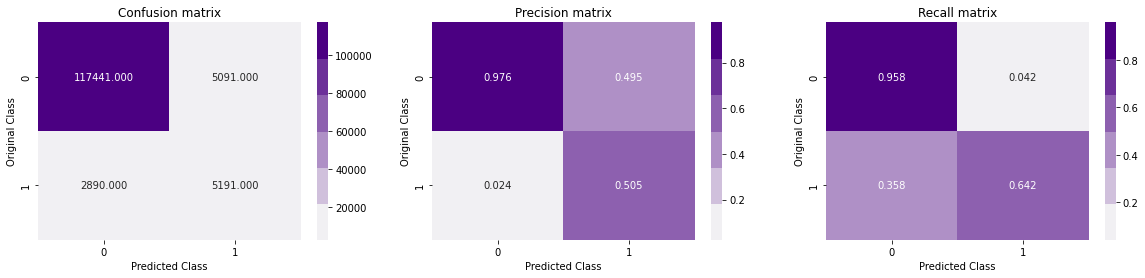

In [ ]:
predicted_y = (test_predict[:,1]>0.23).astype(int)
plot_confusion_matrix(y_test, predicted_y)

- Typically Naive Bayes model performs well on text data but it is not the case for the insincere questions data.Logit model is performing better than the Naive Bayes model.

### Error analysis on Glove embedding based LSTM model

#### Analysis based on the loss values

In [ ]:
# comparing true class with predicted class

wrong_pred_ind = [] # list to store indices of datapoints that were wrongly predicted

for ind in range(len(y_test)):
  if y_pred_test[ind] != y_test.values[ind]: #check whether true class == predicted class
    wrong_pred_ind.append(ind) #add wrongly predicted indices to the list

wrong_pred_ind = np.array(wrong_pred_ind)

for ind in np.random.choice(wrong_pred_ind,20): #print qustions that were wrongly predicted 
  
  print('\n')

  print('True value:',y_test.values[ind],',Predicted value:',y_pred_test[ind])
  print('QUESTION:',X_test['question'].iloc[ind])
  



True value: 0 ,Predicted value: 1
QUESTION: why do not all pakistani hindus come back to india


True value: 0 ,Predicted value: 1
QUESTION: in india why does not the people support premarital sex same sex relationship porn industry business open marriage how can we change the mentality of the indian people how we promote all these how can we make it common here in india


True value: 0 ,Predicted value: 1
QUESTION: why do europeans have pale skin does low melatonin provide an evolutionary benefit


True value: 1 ,Predicted value: 0
QUESTION: what would you do if your jewish girlfriend own father would not come to your wedding because it is on a saturday


True value: 0 ,Predicted value: 1
QUESTION: why can not congress introspect their approach towards fighting elections and stop abusing the pm in every rally


True value: 1 ,Predicted value: 0
QUESTION: do people say bullies are jealous because that is what the victim would like to hear rather than the reason they are being picked 


- It is already mentioned that there are data points that were mislabeled in the data, but the model appears to be performing well on the milabeled data. For example model predicted correct labels for the below milabeled datapoints,

>True value: 0 ,Predicted value: 1

> **QUESTION: we know why men cheat but why do women cheat**


> **QUESTION: for all pedophiles what is your opinion as a pedophile on nepiophilia sexually attraction to toddlers babies**

----------------
- Most of these mislabeled questions that are correctly classified by the model belong to class-1. Model appears to learn the semantics of insincere questions. But model is also making mistakes in predicting the correct class label for few insincere questions such as below,

True value: 1 ,Predicted value: 0

**QUESTION: why do i see less intelligent people everywhere**

True value: 1 ,Predicted value: 0

**QUESTION: what would you do if your jewish girlfriend own father would not come to your wedding because it is on a saturday**


- There appears to be no sincere questions misclassified except for the mislabeled sincere questions which could be due to large amount of sincere data available.

#### Analysis on loss values of each datapoint

In [ ]:
'''np.save('test_predictions',test_predictions)
X_test.to_csv('test_split.csv')
np.save('y_true',y_test.values)'''

test_preds = np.load('test_predictions.npy')
X_test = pd.read_csv('test_split.csv')
y_test = np.load('y_true.npy')

test_y = np.array(y_test.values,dtype=np.float32)

y_pred_test = [1 if pred > 0.34 else 0 for pred in test_preds]
predictions_test = np.array(y_pred_test,dtype=np.float32)

'y_pred_test = [1 if pred > 0.34 else 0 for pred in test_preds]\npredictions_test = np.array(y_pred_test,dtype=np.float32)'

In [ ]:
losses = [] #list to store loss corresponding to each data point in test data

for actual,pred in zip(test_y,avg_preds_test.astype(np.float32())):

  loss = tf.keras.backend.binary_crossentropy(actual,pred) #calcuate the loss for each test prediction
  losses.append(loss.numpy())

losses = np.array(losses)

wrong_pred_ind = [] #index of misclassified data points
for ind in range(len(y_test)):
  if y_pred_test[ind] != y_test.values[ind]:
    wrong_pred_ind.append(ind)

correct_pred_ind = [] ##index of correctly classified data points
for ind in range(len(y_test)):
  if y_pred_test[ind] == y_test.values[ind]:
    correct_pred_ind.append(ind)

print(len(wrong_pred_ind))
print(len(correct_pred_ind))

wrong_pred_ind = np.array(wrong_pred_ind)
correct_pred_ind = np.array(correct_pred_ind)

5127
125486


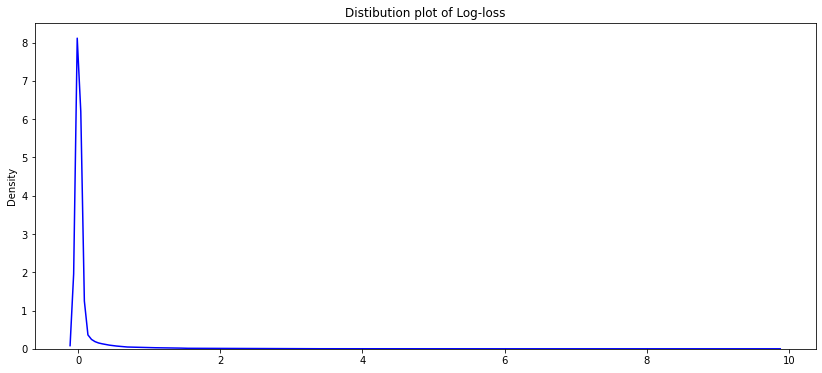

In [ ]:
#distribution of losses
plt.figure(figsize=(14,6))
sns.kdeplot(losses,color = 'blue')
plt.title('Distibution plot of Log-loss')
plt.show()

In [ ]:
print('Percentile values of losses:')
print('-'*30)
for i in range(0,110,10):
  print(i,'%le:',np.round(np.percentile(losses,i),4))

Percentile values of losses:
------------------------------
0 %le: 0.0
10 %le: 0.0001
20 %le: 0.0002
30 %le: 0.0003
40 %le: 0.0006
50 %le: 0.0011
60 %le: 0.0022
70 %le: 0.0053
80 %le: 0.0191
90 %le: 0.1532
100 %le: 9.7644


In [ ]:
print('90-100 Percentile values of losses:')
print('-'*35)
for i in range(90,101):
  print('\t',i,'%le:','\t',np.round(np.percentile(losses,i),4))

90-100 Percentile values of losses:
-----------------------------------
	 90 %le: 	 0.1532
	 91 %le: 	 0.1927
	 92 %le: 	 0.2409
	 93 %le: 	 0.3049
	 94 %le: 	 0.3843
	 95 %le: 	 0.4873
	 96 %le: 	 0.6327
	 97 %le: 	 0.8571
	 98 %le: 	 1.1868
	 99 %le: 	 1.8247
	 100 %le: 	 9.7644


In [ ]:
best_loss = 0.019
avgLoss_start = 0.15
avgLoss_end = 1
worst_loss = 1.0

In [ ]:
bestLoss_questions = X_test.iloc[np.where(losses<=best_loss)]['question'].head(30).values
true_y = y_test.values[np.where(losses<=best_loss)]
pred_y = np.array(y_pred_test)[np.where(losses<=best_loss)]

print('There are',sum(true_y),'insincere questions when loss is less than',best_loss)
print('\n')

count_incorrectLabels = sum([1 if true != pred else 0 for true,pred in zip(true_y,pred_y)])
print('Among',len(true_y),'question with loss less than',best_loss,'there are \'',count_incorrectLabels,'\' no.of questions that were misclassified.')
print('\n')

print('Questions with least loss:'.upper())

for question,actual,prediction in zip(bestLoss_questions,true_y[:30],pred_y[:30]):

  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')
  #print('-'*75)

There are 22 insincere questions when loss is less than 0.019


Among 104464 question with loss less than 0.019 there are ' 0 ' no.of questions that were misclassified.


QUESTIONS WITH LEAST LOSS:
--------------------------------------------------


actual label: 0 	 predicted label: 0


how do i get a job in zomato as business development associate


--------------------------------------------------


actual label: 0 	 predicted label: 0


how can i overcome my phobia of rabbits


--------------------------------------------------


actual label: 0 	 predicted label: 0


which book should be preferred for problem solving for iit jee for organic chemistry


--------------------------------------------------


actual label: 0 	 predicted label: 0


are there good methods of representing irrational numbers inside a computer


--------------------------------------------------


actual label: 0 	 predicted label: 0


what are the chemical properties of polyethene


---------------------

- Almost all the questions with loss less than 0.019 are sincere questions, there are only 22 insincere questions with loss less than equal to 0.019.

- No question was misclassified when the loss is less than 0.019.

- This seems reasonalble due the large amount of data that we have for sincere questions and small amount of data for insincere questions.


In [ ]:
avgLoss_questions = X_test.iloc[np.where((losses>=avgLoss_start)&(losses<=avgLoss_end))]['question'].head(30).values
true_y = y_test.values[np.where((losses>=avgLoss_start)&(losses<=avgLoss_end))]
pred_y = np.array(y_pred_test)[np.where((losses>=avgLoss_start)&(losses<=avgLoss_end))]
print('There are',sum(true_y),'insincere questions when loss is greater than',avgLoss_start,'and less than',avgLoss_end)
print('\n')

count_incorrectLabels = sum([1 if true != pred else 0 for true,pred in zip(true_y,pred_y)])
print('Among',len(true_y),'question with loss greater than',avgLoss_start,'and less than',avgLoss_end,',there are \'',count_incorrectLabels,'\' no.of questions that were misclassified.')
print('\n')

print('Questions with avg loss:'.upper())

for question,actual,prediction in zip(avgLoss_questions,true_y[:30],pred_y[:30]):
  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')
  #print('-'*75)

There are 4668 insincere questions when loss is greater than 0.15 and less than 1


Among 9899 question with loss greater than 0.15 and less than 1 ,there are ' 1840 ' no.of questions that were misclassified.


QUESTIONS WITH AVG LOSS:
--------------------------------------------------


actual label: 1 	 predicted label: 1


if i marry my niece what should my younger brother and my mom should call her


--------------------------------------------------


actual label: 0 	 predicted label: 0


was edith stein murdered by the nazis because she was jewish or because she was catholic


--------------------------------------------------


actual label: 0 	 predicted label: 1


why is everyone angry at trump own tariffs of percent on steel when many people were fine when obama had percent tariffs


--------------------------------------------------


actual label: 0 	 predicted label: 1


is gek l har in halo autistic i have heard of mentally challenged elites called reavers


------------

- There are 10396 questions with loss between 0.15 and 1 and 1840 among them are misclassified. Most of the misclassified points appear to be mislabeled and model seems to predict the true class label for the mislabeled data.


- Most of the insincere questions seems to have a loss between 0.15 and 1 because there are 4668 insincere questions with average loss.


- There are questions that actually belong to label 1 but are mislabeled as 0, model predicted these questions as sincere questions, these mislabeled quesions could have confused the model between sincere and insincere semantics and could have been the reason for recall and precision not improving

In [ ]:
true_y

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
worstLoss_questions = X_test.iloc[np.where(losses>=worst_loss)]['question']#.head(30).values
true_y = y_test.values[np.where(losses>=worst_loss)]
pred_y = np.array(y_pred_test)[np.where(losses>=worst_loss)]

print('There are',sum(true_y),'insincere questions when loss is greater than',worst_loss)
print('\n')

worstLoss_questions_df = pd.DataFrame(worstLoss_questions,columns = ['question'])
worstLoss_questions_df['true_y'] = true_y
worstLoss_questions_df['pred_y'] = pred_y



count_incorrectLabels = sum([1 if true != pred else 0 for true,pred in zip(true_y,pred_y)])
print('Among',len(true_y),'question with loss greater than',worst_loss,'there are \'',count_incorrectLabels,'\' no.of questions that were misclassified.')
print('\n')

print('Questions with high loss:'.upper())

for data in worstLoss_questions_df.sample(30).iterrows():

  print('-'*50)
  print('\n')
  print('actual label:',data[1]['true_y'],'\t predicted label:',data[1]['pred_y'])
  print('\n')
  print(data[1]['question'])
  print('\n')
  #print('-'*75)



There are 2020 insincere questions when loss is greater than 1.0


Among 3287 question with loss greater than 1.0 there are ' 3287 ' no.of questions that were misclassified.


QUESTIONS WITH HIGH LOSS:
--------------------------------------------------


actual label: 1 	 predicted label: 0


why did rahul gandhi slap awdhesh singh irs


--------------------------------------------------


actual label: 0 	 predicted label: 1


modi said he is removing vip culture his mlas are doing the opposite how would modi and his followers defend this blatant show of vip culture and high handedness


--------------------------------------------------


actual label: 0 	 predicted label: 1


when trump and his agents of intollerance hate and opposition to liberal political democracy go to the wax museum do they deserve to be taken back into the community they wanted to trash without a redemptive peace and reconcilliation process


--------------------------------------------------


actual label: 1

- There are 3287 questions that have loss greater than 1, 2020 of the 3287 datapoints belong to insincere class. All the questions that have loss greater than 1 are misclassified by the model.

- Some of the questions that were misclassified are actually mislabeled and model predicted the true label for them. Most of the questions that were misclassified actually belong to insincere class, model was unable to predict the insincere questions with loss greater than 1.


#### Analysis on loss values of misclassified datapoints

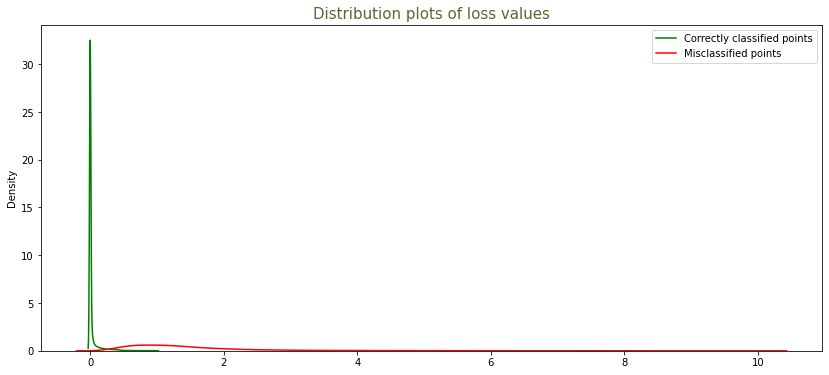

In [ ]:
misclassified_quesLoss = losses[wrong_pred_ind]
correctpredicted_quesLoss = losses[correct_pred_ind]

plt.figure(figsize=(14,6))

#plt.subplot(1,2,1)
sns.kdeplot(correctpredicted_quesLoss,color = 'green',label = 'Correctly classified points')
#plt.legend()

#plt.subplot(1,2,2)
sns.kdeplot(misclassified_quesLoss,color = 'red',label = 'Misclassified points')

plt.legend()
plt.title('Distribution plots of loss values',color = 'darkolivegreen',fontsize=15)
plt.show()

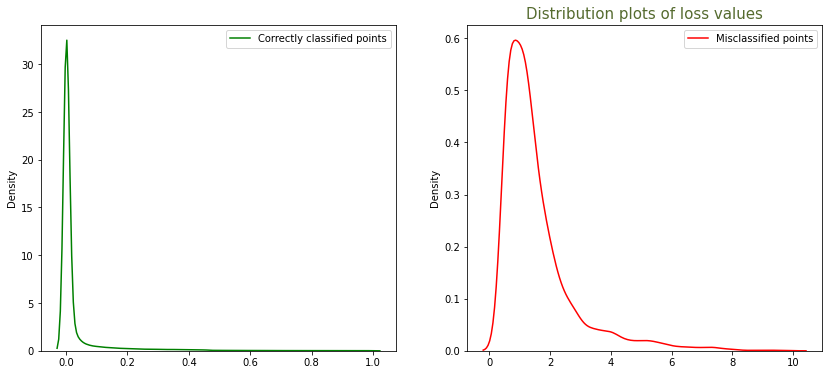

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.kdeplot(correctpredicted_quesLoss,color = 'green',label = 'Correctly classified points')
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(misclassified_quesLoss,color = 'red',label = 'Misclassified points')

plt.legend()
plt.title('Distribution plots of loss values',color = 'darkolivegreen',fontsize=15)
plt.show()

In [ ]:
print('-'*50)
print('|Percentile values of correctly classified points:|')
print('-'*50)
for i in range(0,110,10):
  print('\t',i,'%le:','\t',np.round(np.percentile(correctpredicted_quesLoss,i),4))

print('\n')

print('-'*46)
print('|Percentile values of Misclassified points:|')
print('-'*46)
for i in range(0,110,10):
  print('\t',i,'%le:','\t',np.round(np.percentile(misclassified_quesLoss,i),4))

--------------------------------------------------
|Percentile values of correctly classified points:|
--------------------------------------------------
	 0 %le: 	 0.0
	 10 %le: 	 0.0001
	 20 %le: 	 0.0002
	 30 %le: 	 0.0003
	 40 %le: 	 0.0005
	 50 %le: 	 0.001
	 60 %le: 	 0.0019
	 70 %le: 	 0.0041
	 80 %le: 	 0.0119
	 90 %le: 	 0.0677
	 100 %le: 	 0.9936


----------------------------------------------
|Percentile values of Misclassified points:|
----------------------------------------------
	 0 %le: 	 0.4621
	 10 %le: 	 0.5626
	 20 %le: 	 0.701
	 30 %le: 	 0.8792
	 40 %le: 	 1.0535
	 50 %le: 	 1.2019
	 60 %le: 	 1.3972
	 70 %le: 	 1.6734
	 80 %le: 	 2.0651
	 90 %le: 	 2.9466
	 100 %le: 	 9.7644


In [ ]:
print('-'*55)
print('|90-100 Percentile values of correctly classified points:|')
print('-'*55)
for i in range(90,101):
  print('\t',i,'%le:','\t',np.round(np.percentile(correctpredicted_quesLoss,i),4))

-------------------------------------------------------
|90-100 Percentile values of correctly classified points:|
-------------------------------------------------------
	 90 %le: 	 0.0677
	 91 %le: 	 0.0851
	 92 %le: 	 0.1063
	 93 %le: 	 0.1323
	 94 %le: 	 0.1647
	 95 %le: 	 0.2042
	 96 %le: 	 0.2556
	 97 %le: 	 0.3195
	 98 %le: 	 0.3977
	 99 %le: 	 0.5425
	 100 %le: 	 0.9936


- As we can see from the distribution plots of the losses of misclassified points and correctly classified points there is small overlap between the distributions. 

- All the misclassified points have a loss greater than 0.41 while only 2% of correctly classified data has loss greater than 0.41

In [ ]:
best_loss = 0.1

misclassified_minLoss = X_test.iloc[wrong_pred_ind[np.where(misclassified_quesLoss<1)]]['question'].head(30).values
true_y = y_test.values[wrong_pred_ind[np.where(misclassified_quesLoss<1)]]
pred_y = np.array(y_pred_test)[wrong_pred_ind[np.where(misclassified_quesLoss<1)]]

print('Misclassified questions with least loss:'.upper())
print('\n')

for question,actual,prediction in zip(misclassified_minLoss,true_y[:30],pred_y[:30]):

  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')
  #print('-'*75)

MISCLASSIFIED QUESTIONS WITH LEAST LOSS:


--------------------------------------------------


actual label: 0 	 predicted label: 1


why is everyone angry at trump own tariffs of percent on steel when many people were fine when obama had percent tariffs


--------------------------------------------------


actual label: 0 	 predicted label: 1


is gek l har in halo autistic i have heard of mentally challenged elites called reavers


--------------------------------------------------


actual label: 0 	 predicted label: 1


is donald trump the closest thing the united states has had to a dictator


--------------------------------------------------


actual label: 0 	 predicted label: 1


why muslims coined the green flag with crescent moon and star as islamic flag while it is mughal version of turkish flag


--------------------------------------------------


actual label: 0 	 predicted label: 1


why has pakistan adopted terrorism as an instrument of state policy despite being a n

- The misclassified questions with least logloss(<1.0) have all labels predicted as 1. These questions are indeed insincere but were mislabeled as sincere, all these questions have been correctly identified by the model as insincere.

- It appears that mislabeled insincere questions has least loss values among the misclassifieds.


In [ ]:
misclassified_que_minLoss = X_test.iloc[wrong_pred_ind[np.where((misclassified_quesLoss> 1) & (misclassified_quesLoss < 2))]]['question'].head(30).values
true_y = y_test.values[wrong_pred_ind[np.where((misclassified_quesLoss > 1) & (misclassified_quesLoss < 2))]]
pred_y = np.array(y_pred_test)[wrong_pred_ind[np.where((misclassified_quesLoss > 1) & (misclassified_quesLoss < 2))]]

print('Misclassified questions with moderate loss:'.upper())
print('\n')

for question,actual,prediction in zip(misclassified_que_minLoss,true_y[:30],pred_y[:30]):
  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')

MISCLASSIFIED QUESTIONS WITH MODERATE LOSS:


--------------------------------------------------


actual label: 1 	 predicted label: 0


why do guys hesitate to communicate clearly that they have lost interest in a girl than going distant and then abruptly severing ties


--------------------------------------------------


actual label: 0 	 predicted label: 1


are americans ashamed that they had a dozen of presidents who were slave owners


--------------------------------------------------


actual label: 0 	 predicted label: 1


how many of you do incest sex


--------------------------------------------------


actual label: 0 	 predicted label: 1


was hillary clinton born to a wealthy or a poor family


--------------------------------------------------


actual label: 0 	 predicted label: 1


why do people fuss so much over pineapple on pizza why can not people just respect each other own taste preferences why does it matter so much i just do not get this debate it is not like

- Again mislabeled data appears to be a problem when observed the questions with moderate loss, there are many questons that were mislabeled and model seems to be classifiying them correctly.

- There are some questions where model is predicting them wrongly as sincere while they are actually insincere, model was unable to capture the insncerity for few questions.

In [ ]:
misclassified_que_minLoss = X_test.iloc[wrong_pred_ind[np.where(misclassified_quesLoss>2)]]['question'].head(100).values
true_y = y_test.values[wrong_pred_ind[np.where(misclassified_quesLoss>2)]]
pred_y = np.array(y_pred_test)[wrong_pred_ind[np.where(misclassified_quesLoss>2)]]

print('Misclassified questions with high loss:'.upper())
print('\n')

for question,actual,prediction in zip(misclassified_que_minLoss,true_y[:100],pred_y[:100]):
  print('-'*50)
  print('\n')
  print('actual label:',actual,'\t predicted label:',int(prediction))
  print('\n')
  print(question)
  print('\n')

MISCLASSIFIED QUESTIONS WITH HIGH LOSS:


--------------------------------------------------


actual label: 1 	 predicted label: 0


how was zainab own spiritual journey from wahhabi to an atheist to shia


--------------------------------------------------


actual label: 1 	 predicted label: 0


how does an adult that believes in the likes of santa oz gnomes and gods not drown in the shower


--------------------------------------------------


actual label: 1 	 predicted label: 0


why soldiers are considered honoured or heroes when what they actually do is kill another sentients


--------------------------------------------------


actual label: 1 	 predicted label: 0


is it true that a us navy sniper would be able to clear an area of jungle from mosquitoes with just a sniper rifle


--------------------------------------------------


actual label: 1 	 predicted label: 0


just found out qoura is alt right i had answer to question deleted and they say it was not factual correct

- Most of the questions with losses greater than 2.0 are labeled as sincere by the model.

- Data mislabeling issue can be observed even for the loss greater than 2. 

- Model is miclassifying many insincere questions as sincere,this could be due to the mislabeled data because if we observe the misclassified questions with loss less than 1 all of them are mislabeled as sincere while they were actually insincere. Even though model was able to predict them as insincere, model appears to get confused between sincere and insincere questions because of mislabeling which might be the reason for misclassification for datapoints with loss greater than 2.

- Model performance might have been much better if there are no mislabeld data